In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os

file_name = 'Multimedia_dataset.zip'
zip_path = '/content/drive/MyDrive/Multimedia&Lab/Multimedia_dataset.zip'

!cp "{zip_path}" .
!unzip -q '{file_name}'
!rm '{file_name}'

In [3]:
file_name = 'denoising_testset.zip'
zip_path = '/content/drive/MyDrive/Multimedia&Lab/denoising_testset.zip'

!cp "{zip_path}" .
!unzip -q '{file_name}'
!rm '{file_name}'

In [4]:
%matplotlib notebook
%matplotlib inline

import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as td
import torchvision as tv
from PIL import Image
import matplotlib.pyplot as plt
import nntools as nt

print('Device id: ', torch.cuda.current_device())
print('Available: ', torch.cuda.is_available())
print('Property: ', torch.cuda.get_device_properties(0))

device = 'cuda' if torch.cuda.is_available() else 'cpu'

Device id:  0
Available:  True
Property:  _CudaDeviceProperties(name='Tesla V100-SXM2-16GB', major=7, minor=0, total_memory=16160MB, multi_processor_count=80)


In [5]:
dataset_root_dir = '/content/'
test_dataset_root_dir = '/content/'

In [6]:
# data+noise 코드
def add_noise(img, noise) :
  #for i, data in enumerate(tqdm.tqdm(train_dataloader)):
    '''
    if use_cuda:
      img = data['img'].to('cuda')
      noise = data['noise'].to('cuda')
      '''
    model_input = img + noise
    noise_image = torch.clamp(model_input, 0, 1)

    #image_show(img[0])
    #image_show(noise_image[0])
    #input()
    
    return noise_image

In [8]:
import torch
import torch.utils.data  as data
import os
from PIL import Image
import matplotlib.pyplot as plt

class NoiseDataset(data.Dataset):
  def __init__(self, root_path, size):
    super(NoiseDataset, self).__init__()
    self.root_path = root_path
    self.size = size
    self.transforms = None
    self.examples = None

  def set_mode(self, mode):
    self.mode = mode
    self.transforms = NoiseTransform(self.size, mode)
    if mode == "training":
      train_dir = os.path.join(self.root_path, "train")
      self.examples = [os.path.join(self.root_path, "train", dirs) for dirs in os.listdir(train_dir)]
    elif mode == "augmented" or mode == "augmented2" or mode == "augmented3":
      aug_dir = os.path.join(self.root_path, "train")
      self.examples = [os.path.join(self.root_path, "train", dirs) for dirs in os.listdir(aug_dir)]
    elif mode == "validation":
      val_dir = os.path.join(self.root_path, "validation")
      self.examples = [os.path.join(self.root_path, "validation", dirs) for dirs in os.listdir(val_dir)]
    elif mode == "testing":
      test_dir = os.path.join(self.root_path, "test")
      self.examples = [os.path.join(self.root_path, "test", dirs) for dirs in os.listdir(test_dir)]
    else:
      raise NotImplementedError
  
  def __len__(self):
    return len(self.examples)
  
  def __repr__(self) :
    return "NoiseDataset(mode = {}, image_size = {})" .\
    format(self.mode, self.size)
  
  def __getitem__(self, idx):
    file_name = self.examples[idx]
    image = Image.open(file_name)

    if self.mode == "testing":
      input_img = self.transforms(image)
      new_file_name = file_name.split('/')[3]
      new_file_name = int(new_file_name.split('.')[0])
      return input_img, new_file_name

    elif self.mode == "augmented" or self.mode == "augmented2" or self.mode == "augmented3":
      augmented, noise = self.transforms(image)
      noise_aug = add_noise(augmented, noise)
      return noise_aug, augmented

    else:
      clean, noise = self.transforms(image)
      noise_img = add_noise(clean, noise)
      return noise_img, clean

In [9]:
import torch
from torch.autograd import Variable
from torchvision import transforms

import random

class NoiseTransform(object):
  def __init__(self, size=180, mode="training"):
    super(NoiseTransform, self).__init__()
    self.size = size 
    self.mode = mode
  
  def gaussian_noise(self, img):
    mean = 0
    stddev = 25
    noise = Variable(torch.zeros(img.size()))
    noise = noise.data.normal_(mean, stddev/255.)

    return noise

  def __call__(self, img):
    if (self.mode == "training") | (self.mode == "validation"):
      self.gt_transform = transforms.Compose([
        # transforms.RandomCrop(self.size), 
        transforms.Resize((self.size, self.size), interpolation=2),# 이미지 크기 조절
        transforms.ToTensor()])
      self.noise_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor(),
        transforms.Lambda(self.gaussian_noise),
      ])
      return self.gt_transform(img), self.noise_transform(img)

    elif self.mode == "augmented" :
      self.aug_transform = transforms.Compose([
        # transforms.RandomCrop(self.size), #이미지 자르기
        transforms.Resize((self.size, self.size), interpolation=2),# 이미지 크기 조절
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),#밝기, 대비, 채도, 색조 등 바꾸는 기능
        transforms.RandomHorizontalFlip(p=1), #p의 확률로 좌우반전 실시
        transforms.ToTensor(),                                  
      ])
      self.noise_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor(),
        transforms.Lambda(self.gaussian_noise),
      ])
      return self.aug_transform(img), self.noise_transform(img)

    elif self.mode == "augmented2" :
      self.aug_transform2 = transforms.Compose([
        # transforms.RandomCrop(self.size), #이미지 자르기
        transforms.Resize((self.size, self.size), interpolation=2),# 이미지 크기 조절
        transforms.RandomGrayscale(p=1),#밝기, 대비, 채도, 색조 등 바꾸는 기능
        transforms.RandomVerticalFlip(p=1), # 30도 회전
        transforms.ToTensor(),                                  
      ])
      self.noise_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor(),
        transforms.Lambda(self.gaussian_noise),
      ])
      return self.aug_transform2(img), self.noise_transform(img)
    
    elif self.mode == "augmented3" :
      self.aug_transform3 = transforms.Compose([
        # transforms.RandomCrop(self.size), #이미지 자르기
        transforms.Resize((self.size, self.size), interpolation=2),# 이미지 크기 조절
        transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),#밝기, 대비, 채도, 색조 등 바꾸는 기능
        transforms.RandomVerticalFlip(p=1), # 30도 회전
        transforms.ToTensor(),                                  
      ])
      self.noise_transform = transforms.Compose([
        # transforms.RandomCrop(self.size),
        transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor(),
        transforms.Lambda(self.gaussian_noise),
      ])
      return self.aug_transform3(img), self.noise_transform(img)

    # elif self.mode == "augmented4" :
    #   self.aug_transform4 = transforms.Compose([
    #     # transforms.RandomCrop(self.size), #이미지 자르기
    #     transforms.Resize((self.size, self.size), interpolation=2),# 이미지 크기 조절
    #     transforms.RandomGrayscale(p=1), #밝기, 대비, 채도, 색조 등 바꾸는 기능
    #     transforms.RandomHorizontalFlip(p=1), # 30도 회전
    #     transforms.ToTensor(),                                  
    #   ])
    #   self.noise_transform = transforms.Compose([
    #     # transforms.RandomCrop(self.size),
    #     transforms.Resize((self.size, self.size), interpolation=2),
    #     transforms.ToTensor(),
    #     transforms.Lambda(self.gaussian_noise),
    #   ])
    #   return self.aug_transform4(img), self.noise_transform(img)

    elif self.mode == "testing":
      self.gt_transform = transforms.Compose([
        # transforms.Resize((self.size, self.size), interpolation=2),
        transforms.ToTensor()])
      return self.gt_transform(img)
    else:
      return NotImplementedError

In [10]:
import torch
import torch.utils.data  as data
from torch.utils.data import ConcatDataset
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import tqdm
from PIL import Image

# Change to your data root directory
root_path = "/content/"
# Depend on runtime setting
use_cuda = True

train_dataset = NoiseDataset(root_path, 128)
train_dataset.set_mode("training")
train_dataloader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

train_aug_dataset = NoiseDataset(root_path, 128)
train_aug_dataset.set_mode("augmented")
train_aug_dataloader = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

train_aug_dataset2 = NoiseDataset(root_path, 128)
train_aug_dataset2.set_mode("augmented2")
train_aug_dataloader2 = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

train_aug_dataset3 = NoiseDataset(root_path, 128)
train_aug_dataset3.set_mode("augmented3")
train_aug_dataloader3 = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

# train_aug_dataset4 = NoiseDataset(root_path, 128)
# train_aug_dataset4.set_mode("augmented4")
# train_aug_dataloader4 = data.DataLoader(train_dataset, batch_size=4, shuffle=True)

# train 합치기
modified_dataset = ConcatDataset([train_dataset, train_aug_dataset, train_aug_dataset2, train_aug_dataset3])
print(len(modified_dataset))

val_dataset = NoiseDataset(root_path, 128)
val_dataset.set_mode("validation")
val_dataloader = data.DataLoader(val_dataset, batch_size=4, shuffle=True)

test_dataset = NoiseDataset(root_path, 128)
test_dataset.set_mode("testing")
test_dataloader = data.DataLoader(test_dataset, batch_size=1, shuffle=False)

18000


In [11]:
def myimshow(image, ax=plt):
    image = image.to('cpu').numpy()
    image = np.moveaxis(image, [0, 1, 2], [2, 0, 1])
    image = (image + 1) / 2
    image[image < 0] = 0
    image[image > 1] = 1
    h = ax.imshow(image)
    ax.axis('off')
    return h

In [12]:
def plot(exp, fig, axes, noisy, img, visu_rate=2):
    if exp.epoch % visu_rate != 0:
        return
    with torch.no_grad():
        denoised = exp.net(noisy[np.newaxis].to(exp.net.device))[0]

    axes[0][0].clear()
    axes[0][1].clear()
    axes[0][2].clear()
    axes[1][0].clear()
    axes[1][1].clear()
    axes[1][2].clear()

    myimshow(img, ax=axes[0][0])
    axes[0][0].set_title('Original image')
    myimshow(noisy, ax=axes[0][1])
    axes[0][1].set_title('Noisy image')
    myimshow(denoised, ax=axes[0][2])
    axes[0][2].set_title('Denoised image')
    
    axes[1][0].plot([exp.history[k][0]['loss'] for k in range(exp.epoch)], label="training loss")
    axes[1][0].set_title('training loss')
    axes[1][1].plot([exp.history[k][0]['psnr'] for k in range(exp.epoch)], label="psnr")
    axes[1][1].set_title('psnr')
    axes[1][2].plot([exp.history[k][0]['ssim'] for k in range(exp.epoch)], label="ssim")
    axes[1][2].set_title('ssim')     
    
    plt.tight_layout()
    fig.canvas.draw()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Text(0.5, 1.0, 'Noise Image')

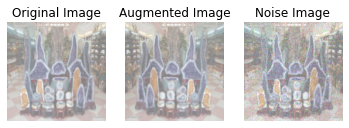

In [13]:
x, x_aug = train_dataset[30], train_aug_dataset[30]
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
myimshow(x[1], ax=ax1)
ax1.set_title("Original Image")
myimshow(x_aug[1], ax=ax2)
ax2.set_title("Augmented Image")
myimshow(x[0], ax=ax3)
ax3.set_title("Noise Image")

In [14]:
import nntools as nt

class NNRegressor(nt.NeuralNetwork):
    def __init__(self):
        super(NNRegressor, self).__init__()
        self.loss = nn.MSELoss()
        
    def criterion(self, y, d):
        return self.loss(y, d)

In [15]:
import pytorch_ssim

class DenoisingStatsManager(nt.StatsManager):

  def __init__(self):
    super(DenoisingStatsManager, self).__init__()

  def init(self):
    super(DenoisingStatsManager, self).init()
    self.running_psnr = 0
    self.count = 0
    self.ssim_value = 0
    self.ssim_loss = 0

  def accumulate(self, loss, x, y, d):
    super(DenoisingStatsManager, self).accumulate(loss, x, y, d)
    mse = torch.sum((y-d)**2).float()
    self.running_psnr += 10 * torch.log10((4*y.numel())/mse)
    self.count += 1
    self.ssim_value += pytorch_ssim.ssim(y, d)
    loss = pytorch_ssim.SSIM(window_size = 11)
    self.ssim_loss += loss(y,d)

  def summarize(self):
    loss = super(DenoisingStatsManager, self).summarize()
    psnr = self.running_psnr / self.count
    ssim = self.ssim_value / self.count
    return {'loss':loss, 'psnr':psnr, 'ssim':ssim}

In [16]:
class DUDnCNN2(NNRegressor):

    def __init__(self, D, C=64):
        super(DUDnCNN2, self).__init__()
        self.D = D

        # compute k(max_pool) and l(max_unpool)
        k = [0]
        k.extend([i for i in range(D//2)])
        k.extend([k[-1] for _ in range(D//2, D+1)])
        l = [0 for _ in range(D//2+1)]
        l.extend([i for i in range(D+1-(D//2+1))])
        l.append(l[-1])

        # holes and dilations for convolution layers
        holes = [2**(kl[0]-kl[1])-1 for kl in zip(k, l)]
        dilations = [i+1 for i in holes]

        # convolution layers
        self.conv = nn.ModuleList()
        self.conv.append(
            nn.Conv2d(3, C, 3, padding=dilations[0], dilation=dilations[0]))
        self.conv.extend([nn.Conv2d(C, C, 3, padding=dilations[i+1],
                                    dilation=dilations[i+1]) for i in range(D)])
        self.conv.append(
            nn.Conv2d(C, 3, 3, padding=dilations[-1], dilation=dilations[-1]))
        # apply He's initialization
        for i in range(len(self.conv[:-1])):
            nn.init.kaiming_normal_(
                self.conv[i].weight.data, nonlinearity='relu')

        # batch normalization
        self.bn = nn.ModuleList()
        self.bn.extend([nn.BatchNorm2d(C, C) for _ in range(D)])
        # initialize the weights of the Batch normalization layers
        for i in range(D):
            nn.init.constant_(self.bn[i].weight.data, 1.25 * np.sqrt(C))

    def forward(self, x):
        D = self.D
        h = F.relu(self.conv[0](x))
        h_buff = []

        for i in range(D//2 - 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))
            h_buff.append(h)

        for i in range(D//2 - 1, D//2 + 1):
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1](h)
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))

        for i in range(D//2 + 1, D):
            j = i - (D//2 + 1) + 1
            torch.backends.cudnn.benchmark = True
            h = self.conv[i+1]((h + h_buff[-j]) / np.sqrt(2))
            torch.backends.cudnn.benchmark = False
            h = F.relu(self.bn[i](h))

        y = self.conv[D+1](h) + x
        return y

In [17]:
lr = 1e-3
net = DUDnCNN2(D=6)
net = net.to(device)
adam = torch.optim.Adam(net.parameters(), lr=lr)
stats_manager = DenoisingStatsManager()
exp11 = nt.Experiment(net, modified_dataset, val_dataset, adam, stats_manager, batch_size = 4,
                     output_dir="denoising11", perform_validation_during_training=True)

Start/Continue training from epoch 0


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:258: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


Epoch 1 | Time: 171.50s | Training Loss: 0.001215 | Evaluation Loss: 0.001102
Epoch 2 | Time: 173.24s | Training Loss: 0.000882 | Evaluation Loss: 0.000947
Epoch 3 | Time: 172.64s | Training Loss: 0.000827 | Evaluation Loss: 0.000952
Epoch 4 | Time: 170.29s | Training Loss: 0.000811 | Evaluation Loss: 0.000907
Epoch 5 | Time: 166.80s | Training Loss: 0.000800 | Evaluation Loss: 0.000948
Epoch 6 | Time: 168.93s | Training Loss: 0.000798 | Evaluation Loss: 0.000903
Epoch 7 | Time: 168.76s | Training Loss: 0.000788 | Evaluation Loss: 0.000870
Epoch 8 | Time: 166.67s | Training Loss: 0.000789 | Evaluation Loss: 0.000944
Epoch 9 | Time: 165.56s | Training Loss: 0.000787 | Evaluation Loss: 0.000865
Epoch 10 | Time: 166.87s | Training Loss: 0.000787 | Evaluation Loss: 0.000890
Epoch 11 | Time: 166.05s | Training Loss: 0.000783 | Evaluation Loss: 0.000921
Epoch 12 | Time: 161.14s | Training Loss: 0.000782 | Evaluation Loss: 0.000884
Epoch 13 | Time: 163.15s | Training Loss: 0.000779 | Evaluati

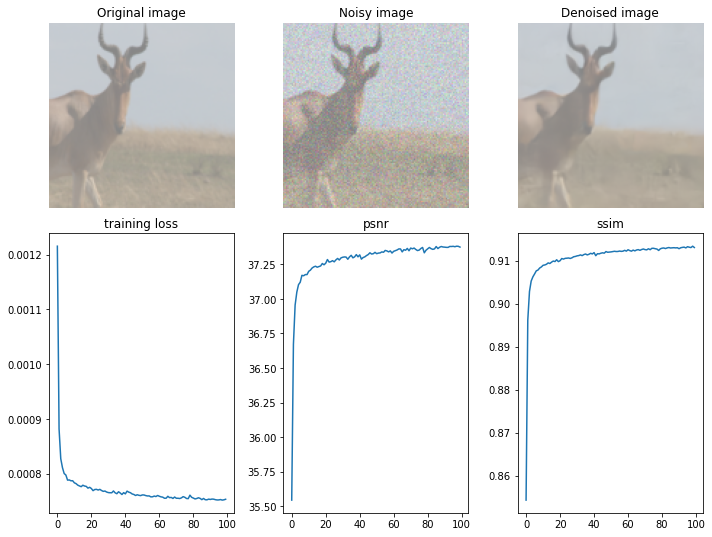

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(10,8))
exp11.run(num_epochs=100, plot=lambda exp: plot(exp, fig=fig, axes=axes, noisy=modified_dataset[500][0], img = modified_dataset[500][1]))

100%|██████████| 1000/1000 [00:16<00:00, 60.49it/s]


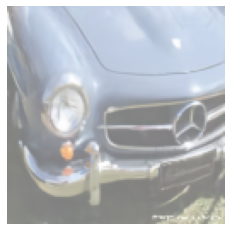

In [19]:
from PIL import Image
from torchvision.utils import save_image

def image_save(img, path):
  #trans = transforms.ToPILImage()
  #img_data = trans(img)
  #img_data.save(path, 'png')
  path += '.png'
  save_image(img, path)

result_save_path = '/content/drive/MyDrive/Multimedia&Lab/result'
for i, data in enumerate(tqdm.tqdm(test_dataloader)):
  noisy, file_name = test_dataset[i]

  with torch.no_grad():
    out_test = exp11.net(noisy[np.newaxis].to(exp11.net.device))[0]
    myimshow(out_test)
    if file_name < 10 :
      new_file_name = 'image_00000' + str(file_name)
    elif file_name < 100 : 
      new_file_name = 'image_0000' + str(file_name)
    elif file_name < 1000 : 
      new_file_name = 'image_000' + str(file_name)
    image_save(out_test, os.path.join(result_save_path, new_file_name))